## Install Packages

In [1]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install keras
!pip install tensorflow
!pip install SciPy
!pip install sklearn
!pip install scikit-learn
!pip install opencv-python
!pip install tensorflow

## Load Modules

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import keras
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg19 import VGG19,preprocess_input , decode_predictions
from keras.applications.vgg16 import VGG16,preprocess_input , decode_predictions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import warnings
from keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
os.listdir("pneumonia/chest_xray/train")

['NORMAL', 'PNEUMONIA']

In [4]:
train_datagen=ImageDataGenerator(zoom_range= 0.5,shear_range=0.3,horizontal_flip= True,preprocessing_function = preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

In [5]:
train = train_datagen.flow_from_directory(directory= "pneumonia/chest_xray/train",target_size=(256,256),batch_size=32)
val = val_datagen.flow_from_directory(directory= "pneumonia/chest_xray/train",target_size=(256,256),batch_size=32)

Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.


In [6]:
t_img , label =train.next()

In [7]:
def plotImage(img_arr,label):
    for im , l in zip(img_arr , label):
        plt.figure(figsize=(5,5))
        plt.imshow(im/255)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


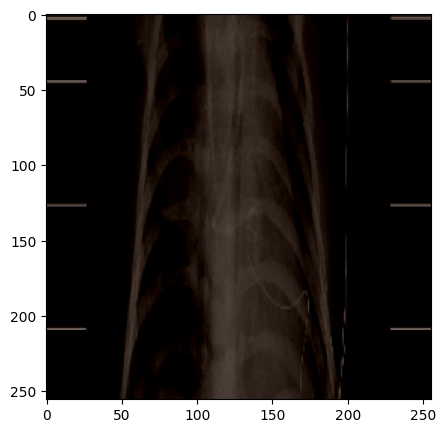

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


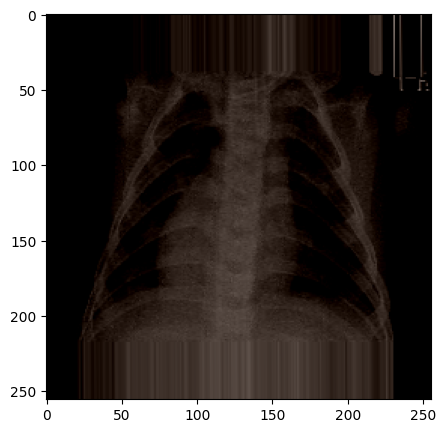

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


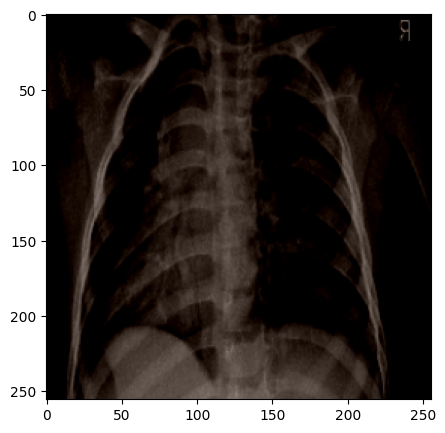

In [8]:
plotImage(t_img[:3],label[:3])

### ii) Using VGG-16 Feature Extractor + SVM

In [9]:
from keras.applications.vgg16 import VGG16,preprocess_input , decode_predictions

In [10]:
base_model=VGG16(input_shape=(256,256,3), include_top= False)

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [13]:
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.models import Model

In [14]:
X= Flatten()(base_model.output)

X= Dense(units= 2,activation= 'softmax')(X)

model= Model(base_model.input,X)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [16]:
from keras.callbacks import ModelCheckpoint , EarlyStopping
#early stopping
es = EarlyStopping(monitor = 'val_accuracy',min_delta=0.01,patience=3,verbose=1)
#model check point
mc = ModelCheckpoint(filepath="best_mmodel.h5",monitor='val_accuracy',min_delta= 0.01,patience=3,verbose=1,save_best_only=True)

cb=[es,mc]

In [17]:
model.compile(optimizer= 'adam',loss= keras.losses.categorical_crossentropy, metrics = ['accuracy'])

In [18]:
his = model.fit(train ,steps_per_epoch= 16,epochs = 5,verbose= 1,callbacks= cb,validation_data=val ,validation_steps = 16)

Epoch 1/5
16/16 [==============================] - ETA: 0s - loss: 4.0892 - accuracy: 0.8086 
Epoch 1: val_accuracy improved from -inf to 0.71289, saving model to best_mmodel.h5
16/16 [==============================] - 379s 24s/step - loss: 4.0892 - accuracy: 0.8086 - val_loss: 7.8786 - val_accuracy: 0.7129
Epoch 2/5
16/16 [==============================] - ETA: 0s - loss: 3.0669 - accuracy: 0.8652 
Epoch 2: val_accuracy improved from 0.71289 to 0.93555, saving model to best_mmodel.h5
16/16 [==============================] - 536s 34s/step - loss: 3.0669 - accuracy: 0.8652 - val_loss: 1.7749 - val_accuracy: 0.9355
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 1.8088 - accuracy: 0.9180 
Epoch 3: val_accuracy did not improve from 0.93555
16/16 [==============================] - 569s 36s/step - loss: 1.8088 - accuracy: 0.9180 - val_loss: 2.9372 - val_accuracy: 0.8809
Epoch 4/5
16/16 [==============================] - ETA: 0s - loss: 0.9493 - accuracy: 0.9375 
Epoch 4: 

0.9683908045977011


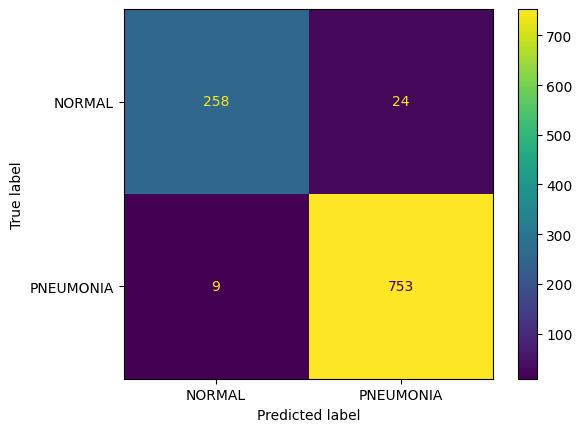

In [28]:
classes={'NORMAL':0, 'PNEUMONIA':1}
X=[]
Y=[]
for cls in classes:
    pth="pneumonia/chest_xray/train/"+cls
    for j in os.listdir(pth):
        img = cv2.imread(pth+'/'+j, 0)
        img = cv2.resize(img, (200,200))
        X.append(img)
        Y.append(classes[cls])

X=np.array(X)
Y=np.array(Y)

X_updated= X.reshape(len(X), -1)

xtrain, xtest, ytrain, ytest = train_test_split(X_updated, Y, test_size=.20)

xtrain= xtrain/255
xtest= xtest/255

clf = SVC(random_state=0, tol=1e-5)
clf.fit(xtrain, ytrain)
predicted = clf.predict(xtest)
acc=accuracy_score(ytest, clf.predict(xtest))
print(acc)
cm=confusion_matrix(ytest, predicted, labels= clf.classes_)
cmdisp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NORMAL", "PNEUMONIA"])
cmdisp.plot()

In [20]:
model.save("best_mmodel.h5")

In [21]:
model = load_model('best_mmodel.h5')
img = load_img('pneumonia/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg', target_size=(256, 256))
i = img_to_array(img)
im = preprocess_input(i)
img = np.expand_dims(im,axis=0)
pred = np.argmax(model.predict(img))
print(pred)

1/1 [==============================] - 1s 530ms/step
1


In [22]:
for k in train.class_indices.keys():
    if train.class_indices[k]==pred:
        print(k)

PNEUMONIA


In [23]:
h = his.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

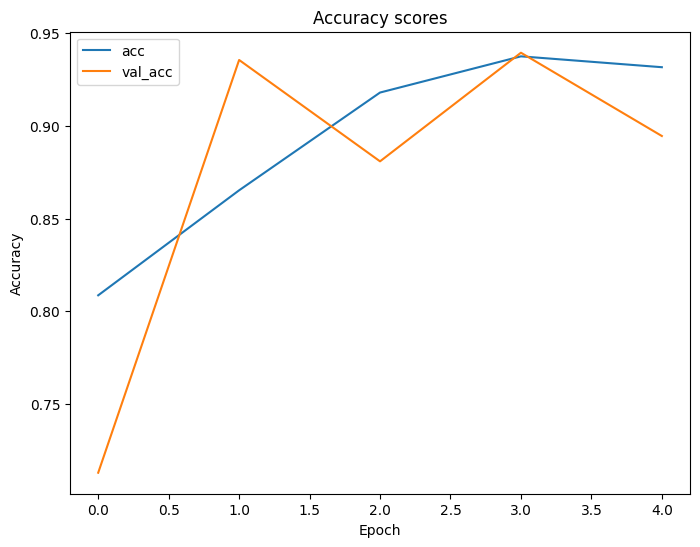

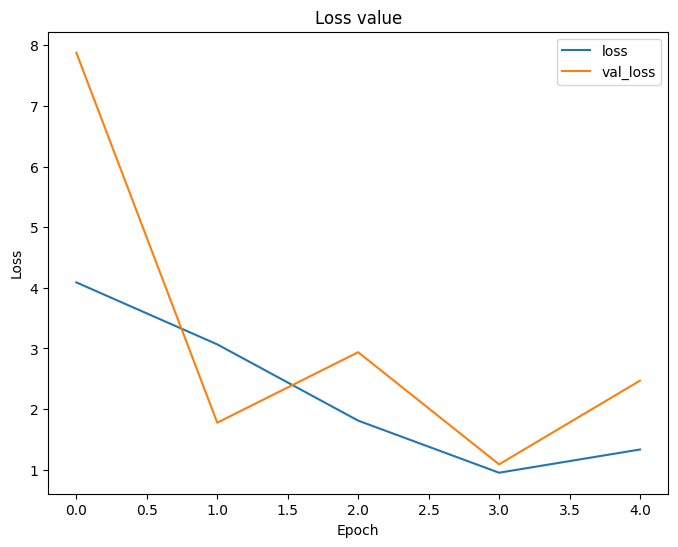

In [24]:
plt.figure(figsize=(8,6))
plt.title('Accuracy scores')
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'])
plt.show()
plt.figure(figsize=(8,6))
plt.title('Loss value')
plt.plot(h['loss'])
plt.plot(h['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
tn, fp, fn, tp = cm.ravel()
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {0:0.2f}%'.format(acc))
print('Precision: {0:0.2f}%'.format(precision))
print('Recall: {0:0.2f}%'.format(recall))
print('F1-score: {0:0.2f}'.format(2*precision*recall/(precision+recall)))

Accuracy: 0.96%
Precision: 96.41%
Recall: 97.91%
F1-score: 97.15


In [26]:
VGG16_ACC=acc*100
print(VGG16_ACC)

95.78544061302682
